Tutorial explanation lies [here](https://adversarial-ml-tutorial.org/adversarial_examples/).
Neural networks, by the nature of their loss surfaces, are especially prone to adversarial examples. The deeper, the proner -_- 

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Text(0, 0.5, 'Output')

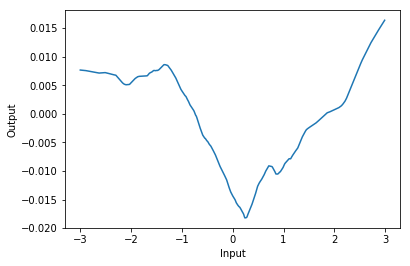

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

Even a randomly trained 2-hidden-layer neural network has such an irregular curve.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

##### Trying out three different simple networks - 2 MLPs and 1 CNN on MNIST

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

0it [00:00, ?it/s]

9920512it [00:01, 8484699.10it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142558.66it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2328101.70it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 53758.41it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [6]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.134117	0.517456	0.081000	0.287926
0.075633	0.265119	0.064000	0.221756
0.059067	0.209327	0.051300	0.182862
0.048983	0.172971	0.047100	0.158080
0.041867	0.146746	0.039800	0.136122
0.036283	0.126991	0.036000	0.123069
0.031433	0.112049	0.034400	0.115684
0.028383	0.100217	0.031600	0.106127
0.025267	0.090489	0.029800	0.099566
0.023117	0.082750	0.028400	0.093423


In [7]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.234733	0.777844	0.084900	0.273286
0.066033	0.221827	0.053000	0.169082
0.042600	0.144013	0.036100	0.119436
0.031450	0.106958	0.035500	0.113118
0.024667	0.083987	0.028400	0.090730
0.021133	0.069940	0.023800	0.077428
0.017433	0.057505	0.023600	0.074507
0.014417	0.047798	0.022600	0.071339
0.011917	0.039085	0.022100	0.075771
0.009633	0.033336	0.021400	0.071544


In [8]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.205467	0.606281	0.028700	0.084898
0.025117	0.081745	0.019800	0.060297
0.016000	0.052822	0.018500	0.055010
0.012567	0.039697	0.013700	0.039630
0.009633	0.030758	0.013600	0.041020
0.004367	0.015435	0.011500	0.033274
0.002983	0.011860	0.011100	0.033227
0.002617	0.010354	0.011300	0.034120
0.002250	0.009334	0.011400	0.034442
0.001900	0.008448	0.011500	0.034796


In [0]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

In [0]:
def fgsm(model, X, y, epsilon):
    """ Construct Fast Gradient Sign Transform adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [0]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

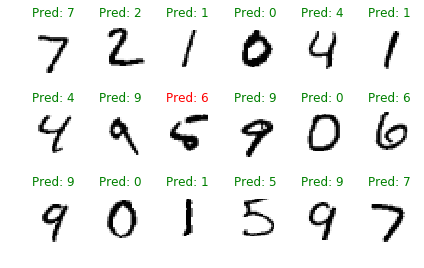

In [13]:
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

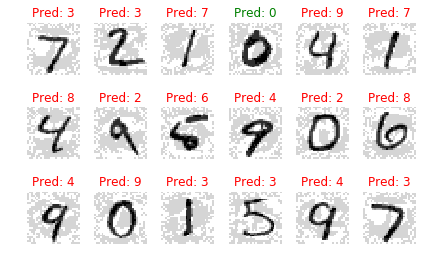

In [14]:
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

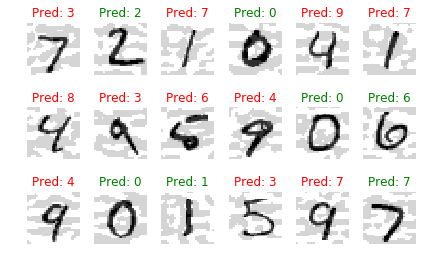

In [15]:
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [16]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
  
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])


2-layer DNN: 0.9262
4-layer DNN: 0.8773
        CNN: 0.4059


Now, we'll attack the network using projected gradient descent.

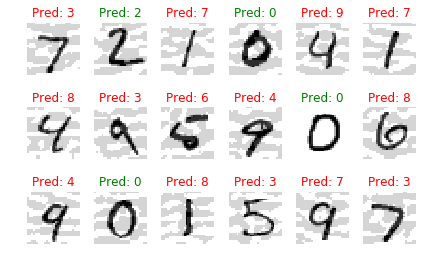

In [17]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()
  
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [18]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

3.592171879063244e-06


2-layer DNN: 0.9653
4-layer DNN: 0.9832
CNN: 0.7331


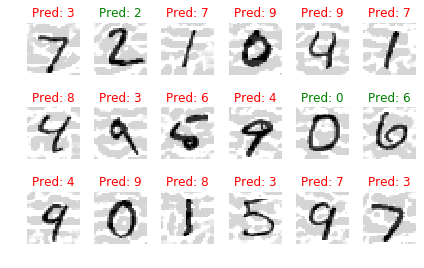

In [19]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

Targeted Attack:

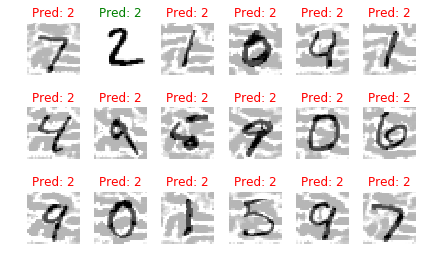

In [20]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

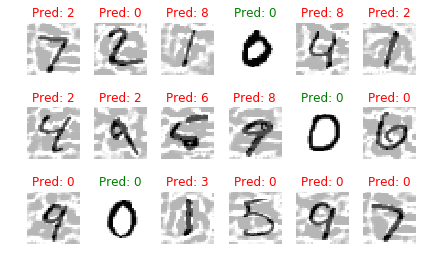

In [21]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

It doesn't always predict 0 as we trained it to. That's because while using this particular loss function to improve predictions for 0 and degrade the prediction of the true class, it inadvertently improved another arbitrary uninvolved class beyond 0.

Advanced adversarial attacks also exist, using combinatorial optimisation and linear integer programming.

Here we worked on the inner maximization problem, and similarly we can go about different ways to solve the outer minimization problem, in order to achieve better, robust models. We need to constantly improve in order to save ourselved from these adversaries lurking everywhere. As they would say, 

![alt text](https://images.amcnetworks.com/amc.com/wp-content/uploads/2017/12/BB_Quote_PlainSite-658.jpg)